<a href="https://colab.research.google.com/github/EmodioAI/model-development/blob/main/GAN_Audio_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Libraries**

In [ ]:
import librosa
import time
import numpy as np
import tensorflow as tf
import IPython
import IPython.display as ipd 
import matplotlib
import matplotlib.pyplot as plt
import random
import pandas as pd
from keras import losses, models, optimizers
from keras.optimizers import Adam
from keras.models import Sequential,Model
from keras.layers import (Layer, Input, Flatten, Dropout, BatchNormalization, Reshape,
                          MaxPool1D, AveragePooling1D, AveragePooling2D, GlobalAveragePooling1D, GlobalAveragePooling2D,
                          Conv2DTranspose, Conv1D, Dense, LeakyReLU, ReLU, Activation,
                          LSTM, SimpleRNNCell, Concatenate,Conv2D,Lambda)

from keras.callbacks import (EarlyStopping, LearningRateScheduler, ModelCheckpoint, TensorBoard, ReduceLROnPlateau)


%matplotlib inline
matplotlib.style.use('ggplot')

# **Dataset**

In [ ]:
# Audio Config
DURATION = 4
SAMPLE_RATE = 16000
AUDIO_SHAPE = SAMPLE_RATE*DURATION
EMOTION_SHAPE = 8
INTENSITY_SHAPE = 1

NOISE_DIM = 500
MFCC = 40

LABEL= 'happy'

ENCODE_SIZE = NOISE_DIM
DENSE_SIZE = 2100

EMOTIONS = [ 'neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('data.csv')

In [ ]:
data

,Unnamed: 0,file_path,emotion,emotional_intensity
0,0,/content/drive/MyDrive/Dataset/Emotional Speec...,calm,3
1,1,/content/drive/MyDrive/Dataset/Emotional Speec...,calm,3
2,2,/content/drive/MyDrive/Dataset/Emotional Speec...,calm,3
3,3,/content/drive/MyDrive/Dataset/Emotional Speec...,happy,2
4,4,/content/drive/MyDrive/Dataset/Emotional Speec...,happy,3
...,...,...,...,...
9358,9358,/content/drive/MyDrive/Dataset/Emotional Speec...,neutral,2
9359,9359,/content/drive/MyDrive/Dataset/Emotional Speec...,neutral,2
9360,9360,/content/drive/MyDrive/Dataset/Emotional Speec...,neutral,2
9361,9361,/content/drive/MyDrive/Dataset/Emotional Speec...,neutral,2


Total samples (frames) =  (96893,)
[0.03297004 0.05498147 0.047723   ... 0.03817822 0.04210593 0.03205411]
Emotion: disgust
Emotional intensity:  2


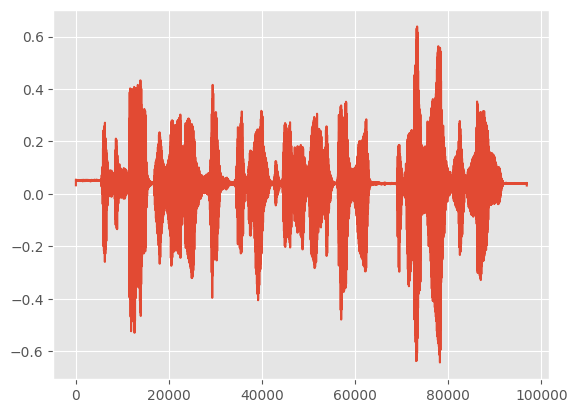

In [ ]:
idx = np.random.randint(0,9363)   # selects an index randomly
fname = data['file_path'][idx]     # selecrtfs path of audio based on selected index
audio_data, _ = librosa.core.load(fname, sr=SAMPLE_RATE)    # reads audio
print("Total samples (frames) = ", audio_data.shape)        # prints shape of audio
print(audio_data)                                           # prints audio
print('Emotion:', data['emotion'][idx])                     # prints emotion of audio
print('Emotional intensity: ', data['emotional_intensity'][idx])      # prints the emotional intensity osf audio
IPython.display.display(ipd.Audio(filename=fname))                # plays audio
plt.plot(audio_data, '-', )                                        # plot audio
plt.show()

In [ ]:
class Config(object):
    def __init__(self,
                 sampling_rate=16000, audio_duration=4, 
                  use_mfcc=False, n_folds=10,
                 n_mfcc=40):
        self.sampling_rate = sampling_rate
        self.audio_duration = audio_duration
        self.use_mfcc = use_mfcc
        self.n_mfcc = n_mfcc

        self.audio_length = self.sampling_rate * self.audio_duration
        if self.use_mfcc:
            self.dim = (self.n_mfcc, 1 + int(np.floor(self.audio_length/512)), 1)
        else:
            self.dim = (self.audio_length, 1)

In [ ]:
def padding(data,input_length):
  if len(data) > input_length:
    max_offset = len(data) - input_length
    offset = np.random.randint(max_offset)
    data = data[offset:(input_length+offset)]
  else:
    if input_length > len(data):
      max_offset = input_length - len(data)
      offset = np.random.randint(max_offset)
    else:
      offset = 0
    data = np.pad(data, (offset, input_length - len(data) - offset), "constant")

  return data

# Load 
def load_train_data(input_length=AUDIO_SHAPE, label = LABEL):
    data = pd.read_csv('data.csv')
    if label != None:
        train_list = data.loc[data.emotion == label]
    else: 
        train_list = data
    cur_batch_size = len(train_list)
    train_fname_list = train_list.file_path
    X = np.empty((cur_batch_size, input_length))
    for i, file_path in enumerate(train_fname_list):
        
        # Read and Resample the audio
        data, _ = librosa.core.load(file_path, sr=SAMPLE_RATE)

        # Random offset / Padding
        if len(data) > input_length:
            max_offset = len(data) - input_length
            offset = np.random.randint(max_offset)
            data = data[offset:(input_length+offset)]
        else:
            if input_length > len(data):
                max_offset = input_length - len(data)
                offset = np.random.randint(max_offset)
            else:
                offset = 0
            data = np.pad(data, (offset, input_length - len(data) - offset), "constant")
        X[i,] = data
    print("Data Loaded...",len(X))
    return X

# Stardize Data 
def normalization(X):
    mean = X.mean(keepdims=True)
    std = X.std(keepdims=True)
    X = (X - mean) / std
    print("Data Normalized...")
    return X

# Rescale Data to be in range [rangeMin, rangeMax]
def rescale(X, rangeMin=-1, rangeMax=+1):
    maxi = X.max()
    mini = X.min()
    X = np.interp(X, (mini, maxi), (rangeMin, rangeMax))
    print("Data Rescaled...")
    return X

def audio_norm(data):
    max_data = np.max(data)
    min_data = np.min(data)
    data = (data-min_data)/(max_data-min_data+1e-6)
    return data-0.5
    

In [ ]:
from keras.utils import Sequence, to_categorical

class DataGenerator(Sequence):
    def __init__(self, config, data_dir, label=None, 
                 batch_size=64, preprocessing_fn=lambda x: x):
        self.config = config
        self.data_dir = data_dir
        self.preprocessing_fn = preprocessing_fn
        self.dim = self.config.dim
        self.label = label
        self.batch_size = batch_size
        self.input_length = self.config.audio_length

        if self.label != None:
            self.train_list = self.data_dir.loc[self.data_dir.emotion == self.label]
        else: 
            self.train_list = self.data_dir

        self.train_fname_list = self.train_list.file_path
        self.steps_per_epoch = len(self.train_list) // self.batch_size

    def __len__(self):
        return self.steps_per_epoch

    def __getitem__(self, index):
       train_batch = self.train_fname_list[index]
       X = self.__data_generation(train_batch)
       return X

    # Load data
    def __data_generation(self, train_batch):
        cur_batch_size = len(train_batch)
        X = np.empty((cur_batch_size, self.input_length))

        for i, file_path in enumerate(train_batch):

            # Read and Resample the audio
            data, _ = librosa.core.load(file_path, sr=self.config.sampling_rate)

            # Random offset / Padding
            if len(data) > self.input_length:
                max_offset = len(data) - self.input_length
                offset = np.random.randint(max_offset)
                data = data[offset:(self.input_length+offset)]
            else:
                if self.input_length > len(data):
                    max_offset = self.input_length - len(data)
                    offset = np.random.randint(max_offset)
                else:
                    offset = 0
                data = np.pad(data, (offset, self.input_length - len(data) - offset), "constant")

            # Normalization + Other Preprocessing
            if self.config.use_mfcc:
                data = librosa.feature.mfcc(y=data, sr=self.config.sampling_rate, n_mfcc=self.config.n_mfcc)
                data = np.expand_dims(data, axis=-1)
            else:
                data = np.squeeze(self.preprocessing_fn(data)[:, np.newaxis])
            X[i,] = data
        print("Data Loaded...", len(X))

        return X


# **GAN Architecture**

In [ ]:
# Generator Model

def generator(OutputShape):
    model = Sequential()
    model.add(Dense(1000, input_shape=(OutputShape,)))
    model.add(LeakyReLU(alpha=0.01))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Reshape((1000, 1)))

    model.add(Conv1D(16, 20, padding='same'))
    model.add(ReLU())
    model.add(BatchNormalization(momentum=0.9))
    model.add(Dropout(rate=0.1))

    model.add(Conv1D(32, 25, padding='same'))
    model.add(ReLU())
    model.add(BatchNormalization(momentum=0.9))
    model.add(Dropout(rate=0.1))

    model.add(Conv1D(64, 50, padding='same'))
    model.add(ReLU())
    model.add(BatchNormalization(momentum=0.9))
    model.add(Dropout(rate=0.1))

    model.add(Conv1D(64, 100, padding='same'))
    model.add(Dropout(rate=0.3))
    model.add(Flatten())
    model.add(Reshape((64000, )))  # Reshape to (64000, 1)
    return model





# Discriminator

def discriminator(InputShape):
    model = Sequential()

    model.add(Reshape((InputShape, 1), input_shape=(InputShape,)))
    model.add(Conv1D(32, 100, strides=7, padding='valid'))
    model.add(ReLU())
    model.add(AveragePooling1D(4))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Dropout(rate=0.1))

    model.add(Conv1D(16, 50, strides=5, padding='valid'))
    model.add(ReLU())
    model.add(AveragePooling1D(4))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Dropout(rate=0.1))

    model.add(Conv1D(8, 25, strides=4, padding='valid'))
    model.add(ReLU())
    model.add(AveragePooling1D(2))
    model.add(BatchNormalization(momentum=0.9))
    model.add(Dropout(rate=0.1))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model


# Stacked Generator and Discriminator
def stacked_G_D(Generator, Discriminator):
    model = Sequential()
    model.add(Generator)
    model.add(Discriminator)
    return model

# Encoder
def encoder(InputShape, EncodeSize):
    model = Sequential()
    model.add(Reshape((InputShape, 1), input_shape=(InputShape,)))
    model.add(Conv1D(32, 100, strides=7, padding='valid'))
    model.add(ReLU())
    model.add(BatchNormalization(momentum=0.9))
    model.add(Dropout(rate=0.1))
    
    model.add(Conv1D(16, 50, strides=5, padding='valid'))
    model.add(ReLU())
    model.add(BatchNormalization(momentum=0.9))
    model.add(Dropout(rate=0.1))

    model.add(Conv1D(8, 25, strides=3, padding='valid'))
    model.add(ReLU())
    model.add(BatchNormalization(momentum=0.9))
    model.add(Dropout(rate=0.1))
    model.add(Flatten())
    model.add(Dense(EncodeSize))
    model.add(LeakyReLU(alpha=0.01))
    return model

# AutoEndoder
def autoEncoder(Encoder, Generator):
    model = Sequential()
    model.add(Encoder)
    model.add(Generator)
    return model


In [ ]:

class AudioGAN:
    def __init__(self, label):

        # Generate models
        self.enc = encoder(AUDIO_SHAPE, ENCODE_SIZE)
        self.gen = generator( AUDIO_SHAPE)
        self.dis = discriminator(AUDIO_SHAPE)
        self.stackGenDis = stacked_G_D(self.gen, self.dis)
        # self.autoencoder = autoEncoder(self.enc, self.gen)  
        
        # Compile models
        self.opt = Adam(lr = 0.0002, beta_1 = 0.9)
        self.gen.compile(loss = 'binary_crossentropy', optimizer = self.opt, metrics = ['accuracy'])
        self.dis.compile(loss = 'binary_crossentropy', optimizer = self.opt, metrics = ['accuracy'])
        # self.autoencoder.compile(loss = 'mse',         optimizer = self.opt, metrics = ['accuracy'])
        self.stackGenDis.compile(loss = 'binary_crossentropy', optimizer = self.opt,  metrics = ['accuracy'])

        # Set training data
        self.trainData =  DataGenerator(config=config, data_dir=data, label='happy', 
                                    preprocessing_fn=audio_norm)
        self.predictData = DataGenerator(config=config, data_dir=data, label='neutral', 
                                    preprocessing_fn=audio_norm)
       


        self.disLossHist = []
        self.genLossHist = []

    # Train GAN
    def train_gan(self, epochs = 20, batch = 32, save_interval = 2):
        for cnt in range(epochs):
          
            # Train discriminator
            halfBatch = int(batch/2)
            random_index = np.random.randint(0, len(self.trainData) - halfBatch)
            random_index_predict = np.random.randint(0, len(self.predictData) - halfBatch)

            legit_audios = self.trainData[random_index: int(random_index + halfBatch)]
            gen_noise = self.predictData[random_index_predict: int(random_index_predict + halfBatch)]

            syntetic_audios = self.gen.predict(gen_noise)

            x_combined_batch = np.concatenate((legit_audios, syntetic_audios))
            y_combined_batch = np.concatenate((np.ones((halfBatch, 1)), np.zeros((halfBatch, 1))))
            d_loss = self.dis.train_on_batch(x_combined_batch, y_combined_batch)
            
            # Update stacked discriminator weights
            self.stackGenDis.layers[1].set_weights(self.dis.get_weights())
    
            # Include discriminator loss
            d_loss_mean = np.mean(d_loss)
            self.disLossHist.append(d_loss_mean)

            # Train stacked generator
            noise = self.predictData[random_index_predict: int(random_index_predict + batch)]
            y_mislabled = np.ones((batch, 1))
            g_loss = self.stackGenDis.train_on_batch(noise, y_mislabled)

            # Update generator Weights
            self.gen.set_weights(self.stackGenDis.layers[0].get_weights())
            
            # Include generator loss
            g_loss_mean = np.mean(g_loss)
            self.genLossHist.append(g_loss_mean)
            
            if cnt % int(save_interval/2) == 0:
                print("epoch: %d" % (cnt))
                print("Discriminator_loss: %f, Generator_loss: %f" % (d_loss_mean, g_loss_mean))
            if cnt % save_interval == 0:
                self.show_gen_samples(2)
     
    # Plot a number of generated samples
    def show_gen_samples(self, samples = 2):
        random_index_predict = np.random.randint(0, len(self.predictData) - samples)

        samplePlot = []
        fig        = plt.figure(figsize = (1, samples))
        noise      = self.predictData[random_index_predict: int(random_index_predict + samples)]
        audios     = self.gen.predict(noise)    
        print('Neutral Data')
        for i, audio in enumerate(noise):
            IPython.display.display(ipd.Audio(data = audio, rate = SAMPLE_RATE))
            samplePlot.append(fig.add_subplot(1, samples, i+1))
            samplePlot[i].plot(audio.flatten(), '.', )   
        print('Synthesised Data')
        for i, audio in enumerate(audios):
            IPython.display.display(ipd.Audio(data = audio, rate = SAMPLE_RATE))
            samplePlot.append(fig.add_subplot(1, samples, i+1))
            samplePlot[i].plot(audio.flatten(), '.', )
        plt.gcf().set_size_inches(25, 5)
        plt.subplots_adjust(wspace=0.3,hspace=0.3)
        plt.show()
       
    # # Train autoencoder
    # def train_autoencoder(self, epochs = 20,  save_internal = 2, batch = 32):
    #     for cnt in range(epochs):
    #         random_index = np.random.randint(0, len(self.trainData) - batch)
    #         legit_audios = self.trainData[random_index : int(random_index + batch)]
    #         loss = self.autoencoder.train_on_batch(legit_audios, legit_audios)
    #         if cnt % save_internal == 0 : 
    #             print("Epoch: ", cnt, ", Loss: ", loss)

In [ ]:
class CycleGAN:
    def __init__(self, audio_shape):
        self.enc_A = encoder(AUDIO_SHAPE, ENCODE_SIZE)
        self.gen_A2B = generator(AUDIO_SHAPE)
        self.dis_B = discriminator(AUDIO_SHAPE)
        self.stackGenDis_B = stacked_G_D(self.gen_A2B, self.dis_B)

        self.enc_B = encoder(AUDIO_SHAPE, ENCODE_SIZE)
        self.gen_B2A = generator(AUDIO_SHAPE)
        self.dis_A = discriminator(AUDIO_SHAPE)
        self.stackGenDis_A = stacked_G_D(self.gen_B2A, self.dis_A)

        self.opt = Adam(lr=0.0002, beta_1=0.9)

        self.gen_A2B.compile(loss='binary_crossentropy', optimizer=self.opt, metrics=['accuracy'])
        self.dis_B.compile(loss='binary_crossentropy', optimizer=self.opt, metrics=['accuracy'])
        self.stackGenDis_B.compile(loss='binary_crossentropy', optimizer=self.opt, metrics=['accuracy'])

        self.gen_B2A.compile(loss='binary_crossentropy', optimizer=self.opt, metrics=['accuracy'])
        self.dis_A.compile(loss='binary_crossentropy', optimizer=self.opt, metrics=['accuracy'])
        self.stackGenDis_A.compile(loss='binary_crossentropy', optimizer=self.opt, metrics=['accuracy'])

        self.trainData_A = DataGenerator(config=config, data_dir=data, label='happy', preprocessing_fn=audio_norm)
        self.trainData_B = DataGenerator(config=config, data_dir=data, label='neutral', preprocessing_fn=audio_norm)

        self.disLossHist_A = []
        self.genLossHist_A = []
        self.disLossHist_B = []
        self.genLossHist_B = []

    def train_gan(self, epochs=20, batch=32, save_interval=2):
        for cnt in range(epochs):
            halfBatch = int(batch / 2)
            random_index_A = np.random.randint(0, len(self.trainData_A) - halfBatch)
            random_index_B = np.random.randint(0, len(self.trainData_B) - halfBatch)

            legit_audios_A = self.trainData_A[random_index_A: int(random_index_A + halfBatch)]
            legit_audios_B = self.trainData_B[random_index_B: int(random_index_B + halfBatch)]


            # Train discriminator A
            gen_noise_A = self.gen_B2A.predict(legit_audios_B)
            syntetic_audios_A = self.gen_A2B.predict(legit_audios_A)
            print(syntetic_audios_A[0].shape)

            x_combined_batch_A = np.concatenate((legit_audios_A, syntetic_audios_A))
            y_combined_batch_A = np.concatenate((np.ones((halfBatch, 1)), np.zeros((halfBatch, 1))))
            d_loss_A = self.dis_A.train_on_batch(x_combined_batch_A, y_combined_batch_A)

            # Train discriminator B
            gen_noise_B = self.gen_A2B.predict(legit_audios_A)
            syntetic_audios_B = self.gen_B2A.predict(legit_audios_B)

            x_combined_batch_B = np.concatenate((legit_audios_B, syntetic_audios_B))
            y_combined_batch_B = np.concatenate((np.ones((halfBatch, 1)), np.zeros((halfBatch, 1))))
            d_loss_B = self.dis_B.train_on_batch(x_combined_batch_B, y_combined_batch_B)

            self.stackGenDis_A.layers[1].set_weights(self.dis_A.get_weights())
            self.stackGenDis_B.layers[1].set_weights(self.dis_B.get_weights())

            self.disLossHist_A.append(np.mean(d_loss_A))
            self.disLossHist_B.append(np.mean(d_loss_B))

            # Train generators
            noise_A = self.trainData_A[random_index_A: int(random_index_A + batch)]
            noise_B = self.trainData_B[random_index_B: int(random_index_B + batch)]

            # Train generator A2B
            y_mislabeled_A = np.ones((batch, 1))
            g_loss_A2B = self.stackGenDis_B.train_on_batch(noise_A, y_mislabeled_A)

            # Train generator B2A
            y_mislabeled_B = np.ones((batch, 1))
            g_loss_B2A = self.stackGenDis_A.train_on_batch(noise_B, y_mislabeled_B)

            self.gen_A2B.set_weights(self.stackGenDis_B.layers[0].get_weights())
            self.gen_B2A.set_weights(self.stackGenDis_A.layers[0].get_weights())

            self.genLossHist_A.append(np.mean(g_loss_A2B))
            self.genLossHist_B.append(np.mean(g_loss_B2A))

            if cnt % int(save_interval / 2) == 0:
                print("Epoch: %d" % (cnt))
                print("Discriminator A loss: %f, Generator A2B loss: %f" % (np.mean(d_loss_A), np.mean(g_loss_A2B)))
                print("Discriminator B loss: %f, Generator B2A loss: %f" % (np.mean(d_loss_B), np.mean(g_loss_B2A)))

            if cnt % save_interval == 0:
                self.show_gen_samples(2)
                    # Plot a number of generated samples
    def show_gen_samples(self, samples=2):
        random_index_predict = np.random.randint(0, len(self.trainData_B) - samples)

        samplePlot = []
        fig = plt.figure(figsize=(1, samples))
        noise = self.trainData_B[random_index_predict: int(random_index_predict + samples)]
        
        audio_A = self.gen_A2B.predict(noise)  # Generate output using generator A2B
        audio_B = self.gen_B2A.predict(noise)  # Generate output using generator B2A

        print('Neutral Data')
   
        for i, audio in enumerate(noise):
            IPython.display.display(ipd.Audio(data = audio, rate = SAMPLE_RATE))
            samplePlot.append(fig.add_subplot(1, samples, i+1))
            samplePlot[i].plot(audio.flatten(), '.', )

        print('Synthesized Data - A2B')

        for i, audio in enumerate(audio_A):
            IPython.display.display(ipd.Audio(data = audio, rate = SAMPLE_RATE))
            samplePlot.append(fig.add_subplot(1, samples, i+1))
            samplePlot[i].plot(audio.flatten(), '.', )

        print('Synthesized Data - A2B')

        for i, audio in enumerate(audio_B):
            IPython.display.display(ipd.Audio(data = audio, rate = SAMPLE_RATE))
            samplePlot.append(fig.add_subplot(1, samples, i+1))
            samplePlot[i].plot(audio.flatten(), '.', )

        plt.gcf().set_size_inches(25, 5)
        plt.subplots_adjust(wspace=0.3, hspace=0.3)
        plt.show()



# **Train Model**

In [ ]:
d = discriminator(AUDIO_SHAPE)
d.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_3 (Reshape)         (None, 64000, 1)          0         
                                                                 
 conv1d_8 (Conv1D)           (None, 9129, 32)          3232      
                                                                 
 re_lu_6 (ReLU)              (None, 9129, 32)          0         
                                                                 
 average_pooling1d_3 (Averag  (None, 2282, 32)         0         
 ePooling1D)                                                     
                                                                 
 batch_normalization_7 (Batc  (None, 2282, 32)         128       
 hNormalization)                                                 
                                                                 
 dropout_7 (Dropout)         (None, 2282, 32)         

In [ ]:
g = generator(AUDIO_SHAPE)
g.summary()

Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_39 (Dense)            (None, 1000)              64001000  
                                                                 
 leaky_re_lu_26 (LeakyReLU)  (None, 1000)              0         
                                                                 
 batch_normalization_128 (Ba  (None, 1000)             4000      
 tchNormalization)                                               
                                                                 
 reshape_52 (Reshape)        (None, 1000, 1)           0         
                                                                 
 conv1d_129 (Conv1D)         (None, 1000, 16)          336       
                                                                 
 re_lu_111 (ReLU)            (None, 1000, 16)          0         
                                                     

In [ ]:
s = stacked_G_D(g,d)
s.summary()

Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_49 (Sequential)  (None, 64000)             64530744  
                                                                 
 sequential_4 (Sequential)   (None, 1)                 32369     
                                                                 
Total params: 64,563,113
Trainable params: 64,560,777
Non-trainable params: 2,336
_________________________________________________________________


In [ ]:
e = encoder(AUDIO_SHAPE, ENCODE_SIZE)
a = autoEncoder(e, g)
a.summary()

In [ ]:
config = Config(sampling_rate=16000, audio_duration=4,use_mfcc=False)

In [ ]:
myGan = AudioGAN(label=LABEL)

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
myGan = CycleGAN(AUDIO_SHAPE)

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


# **Train Autoencoder**

In [ ]:
start = time.time()
myGan.train_autoencoder(epochs = 100, save_internal = 10, batch = 32)
end = time.time()
total = round(end - start, 2)
print("\nExecution Time: ", total, "s")

In [ ]:
INDEX = 11
sample = myGan.trainData[INDEX]

print("Original:")
IPython.display.display(ipd.Audio(data = sample, rate = SAMPLE_RATE))
# librosa.output.write_wav(AUTO_ENCODER_PATH + "AE_Original_" + LABEL + ".wav", 
#                          y = sample, sr = SAMPLE_RATE , norm = True)
result = myGan.autoencoder.predict(sample.reshape((1,AUDIO_SHAPE))).flatten()

print("Result:")
IPython.display.display(ipd.Audio(data = result, rate = SAMPLE_RATE))
# librosa.output.write_wav(AUTO_ENCODER_PATH + "AE_Result_" + LABEL + ".wav", 
#                          y = result, sr = SAMPLE_RATE , norm = True)

fig      = plt.figure(figsize=(1, 2))
Original = fig.add_subplot(1, 2, 1)
Result   = fig.add_subplot(1, 2, 2)

Original.set_title('Original')
Result.set_title('Result')

Original.plot(sample, '.', color ='blue')
Result.plot(result, '.', color ='green')

plt.gcf().set_size_inches(15, 4)
plt.subplots_adjust(wspace=0.2,hspace=0.3)
plt.show()

# fig.savefig(PICTURE_PATH + "AE_Compare_" + LABEL + ".png", bbox_inches = "tight")

# **Training GAN**

In [ ]:
start = time.time()
myGan.train_gan(epochs = 1000, batch = 32, save_interval = 10)
end = time.time()
total = round(end - start, 2)
print("Execution Time: ", total, "s")

Data Loaded... 16
Data Loaded... 16
(64000,)
(64000,)
1/1 [==============================] - 0s 150ms/step
(64000,)


1/1 [==============================] - 0s 21ms/step


Data Loaded... 32
Data Loaded... 32


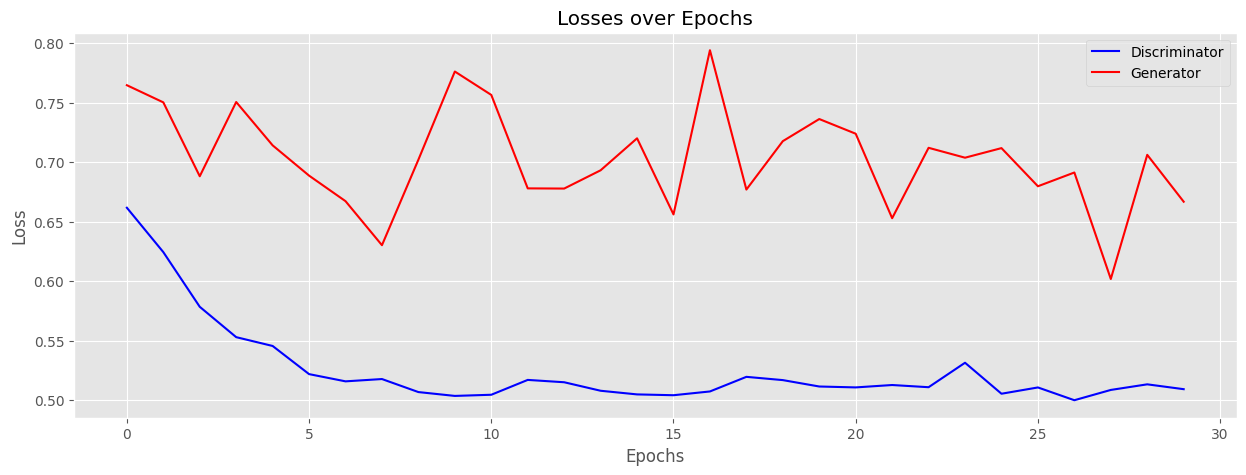

In [ ]:
plt.title('Losses over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.plot(myGan.disLossHist, '-', label = 'Discriminator', color = 'blue')
plt.plot(myGan.genLossHist, '-', label = 'Generator',     color = 'red')
plt.legend(loc = 'best')

plt.gcf().set_size_inches(15, 5)
plt.show()

# **Predictions**

In [ ]:
!pip install gTTS


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
input_text ='The secret to a happy life is not to spend'

In [ ]:
from gtts import gTTS

tts = gTTS(input_text, lang='en')
tts.save('test.wav')

In [ ]:
test_audio, _ = librosa.core.load('test.wav', sr=SAMPLE_RATE)    # reads audio
test_audio =padding(test_audio,AUDIO_SHAPE)
len(test_audio)

64000

Original:


1/1 [==============================] - 0s 19ms/step
Result:


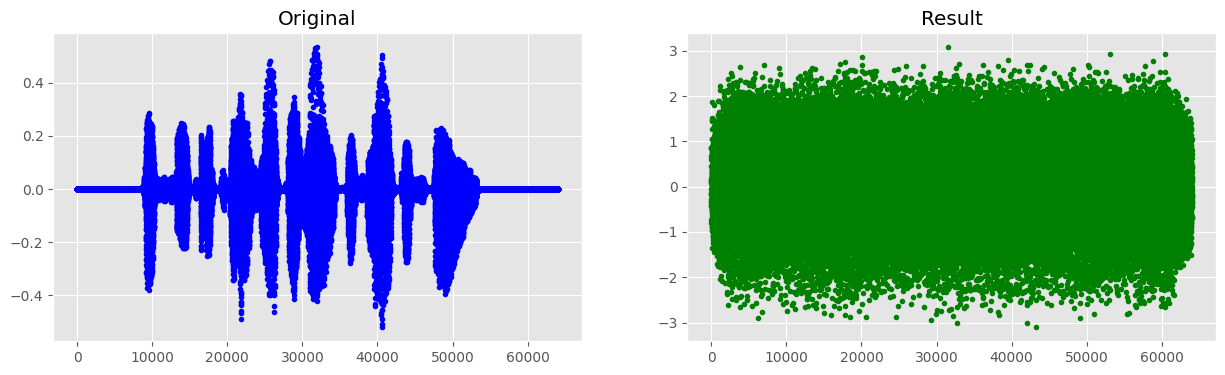

In [ ]:

print("Original:")
IPython.display.display(ipd.Audio(data = test_audio, rate = SAMPLE_RATE))

result = myGan.gen.predict(test_audio.reshape((1,AUDIO_SHAPE))).flatten()

print("Result:")
IPython.display.display(ipd.Audio(data = result, rate = SAMPLE_RATE))

fig      = plt.figure(figsize=(1, 2))
Original = fig.add_subplot(1, 2, 1)
Result   = fig.add_subplot(1, 2, 2)

Original.set_title('Original')
Result.set_title('Result')

Original.plot(test_audio, '.', color ='blue')
Result.plot(result, '.', color ='green')

plt.gcf().set_size_inches(15, 4)
plt.subplots_adjust(wspace=0.2,hspace=0.3)
plt.show()

# fig.savefig(PICTURE_PATH + "AE_Compare_" + LABEL + ".png", bbox_inches = "tight")